<a href="https://colab.research.google.com/github/myriamgoyet/supervised-ML--conversion-rate/blob/main/conversion_rate_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conversion Rate Challenge

➡️ The goal of this project is to train different models in order to maximize the F1 score.

In [10]:
!pip install optuna

In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# import preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier)
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
import optuna
from sklearn.base import BaseEstimator, ClassifierMixin


# import metrics
from sklearn.metrics import (f1_score,
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             RocCurveDisplay,
                             roc_curve,
                             precision_recall_curve)
# import visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


In [13]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!ls '/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML'

 conversion_data_test.csv	'Copie de model_metrics.csv'
 conversion_data_train.csv	'model_metrics (2).gsheet'
 conversion_rate_project.ipynb


In [18]:
# Files path
conversion_data_train = '/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/conversion_data_train.csv'
conversion_data_test = '/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/conversion_data_test.csv'

# Load train dataset
df_train = pd.read_csv(conversion_data_train)

# Part 1: EDA

In [19]:
df_train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [20]:
df_train.shape

(284580, 6)

In [21]:
df_train.isna().sum()

,0
country,0
age,0
new_user,0
source,0
total_pages_visited,0
converted,0


In [22]:
df_train.dtypes

,0
country,object
age,int64
new_user,int64
source,object
total_pages_visited,int64
converted,int64


In [23]:
df_train.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [24]:
df_train["converted"].value_counts()/df_train.shape[0]*100

,count
converted,
0,96.774194
1,3.225806


In [25]:
df_train["country"].value_counts()/df_train.shape[0]*100

,count
country,
US,56.266779
China,24.289128
UK,15.335231
Germany,4.108862


In [26]:
# conversion rate per country
df_train.groupby("country")["converted"].mean() * 100

,converted
country,
China,0.128758
Germany,6.243051
UK,5.249651
US,3.790812


Text(0.5, 1.0, 'Train set: Countries')

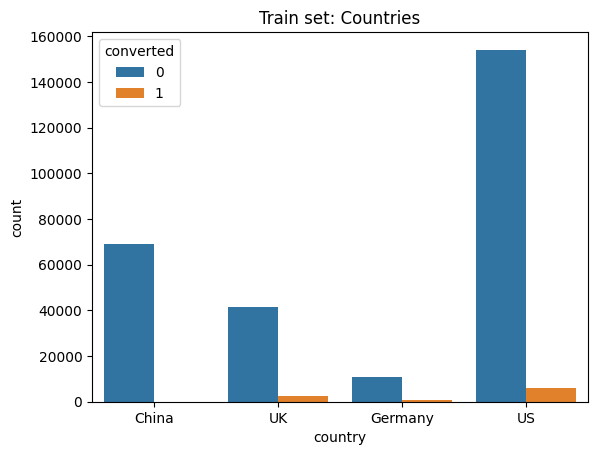

In [27]:
sns.countplot(x='country', data=df_train, hue = "converted")
plt.title('Train set: Countries')


In [28]:
px.histogram(df_train, x="age", color = "converted", title = "train set : histogram age " )

In [29]:
# Calculate conversion rate per age
conversion_rate_by_age = df_train.groupby("age")["converted"].mean().reset_index()
conversion_rate_by_age["conversion_rate"] = conversion_rate_by_age["converted"] * 100

# Create scatter plot
fig = px.scatter(
    conversion_rate_by_age,
    x="age",
    y="conversion_rate",
    title="Conversion Rate by Age",
    labels={"age": "Age", "conversion_rate": "Conversion Rate (%)"},
    trendline="lowess"
)

fig.show()

<Axes: ylabel='age'>

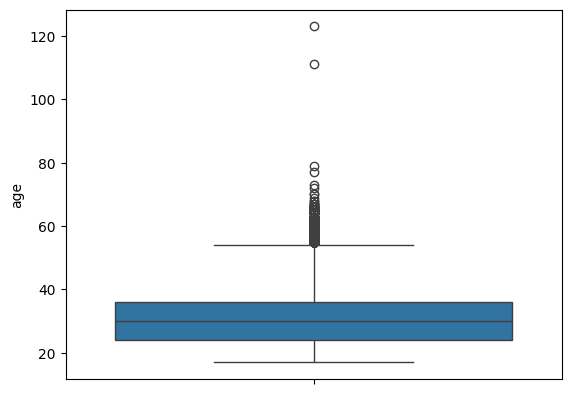

In [30]:
sns.boxplot(df_train['age'])

In [31]:
px.histogram(df_train, x="total_pages_visited", color = "converted" ,title = "train set : histogram total_pages_visited")

In [32]:
# Calculate conversion rate per page visited
conversion_rate_by_page_visited = df_train.groupby("total_pages_visited")["converted"].mean().reset_index()
conversion_rate_by_page_visited["conversion_rate"] = conversion_rate_by_page_visited["converted"] * 100

# Create scatter plot
fig = px.scatter(
    conversion_rate_by_page_visited,
    x="total_pages_visited",
    y="conversion_rate",
    title="Conversion Rate by page visited",
    labels={"total_pages_visited": "total_pages_visited", "conversion_rate": "Conversion Rate (%)"},
    trendline="lowess"
)

fig.show()

<Axes: ylabel='total_pages_visited'>

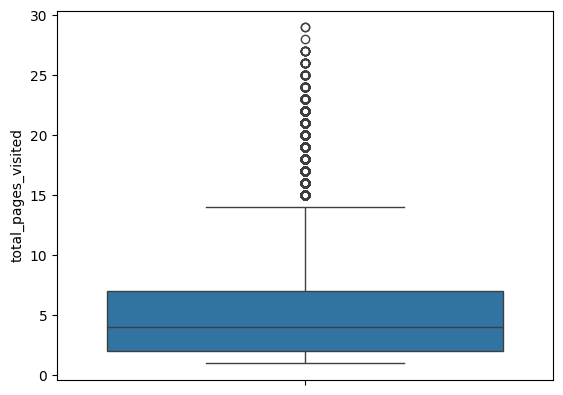

In [33]:
sns.boxplot(df_train['total_pages_visited'])

In [34]:
df_train["source"].value_counts()/df_train.shape[0]*100

,count
source,
Seo,49.011526
Ads,28.121091
Direct,22.867384


In [35]:
# conversion rate per source
df_train.groupby("source")["converted"].mean() * 100

,converted
source,
Ads,3.480075
Direct,2.781363
Seo,3.287280


Text(0.5, 1.0, 'Train set: Source')

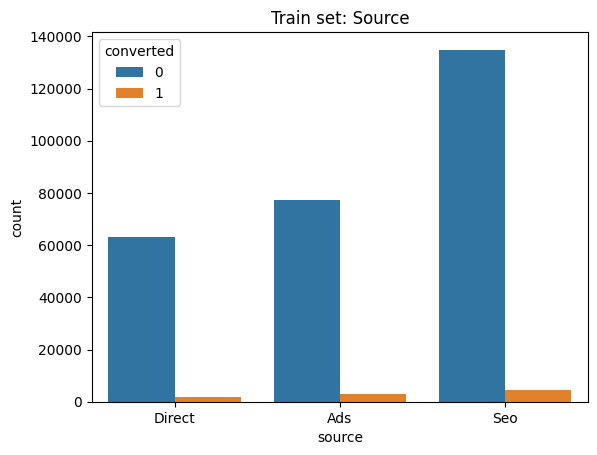

In [36]:
sns.countplot(x='source', data=df_train, hue = "converted")
plt.title('Train set: Source')

In [37]:
df_train.groupby("new_user")["converted"].mean() * 100

,converted
new_user,
0,7.193288
1,1.405165


<Axes: xlabel='new_user', ylabel='count'>

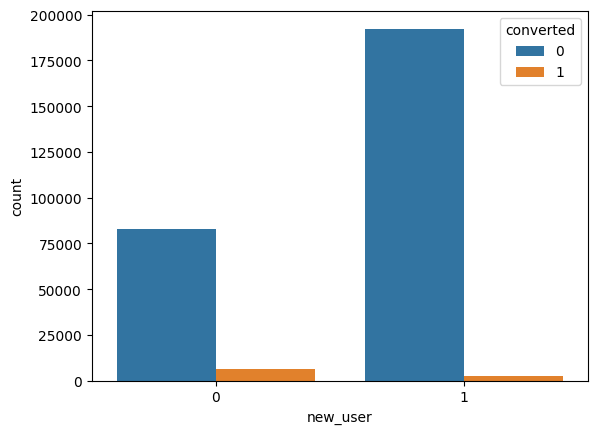

In [38]:
sns.countplot(df_train, x="new_user", hue = "converted")

 ### 📝 EDA keys Insights:
  - The training dataset contains 6 columns and 285,000 rows, with each row representing a potential client who visited the website.
  - "Converted" clients are those who registered for the newsletter. They represent only 3.2% of the total website visitors.
  - The dataset has no missing values.
  - Visitors are primarily from the US (56%), China (24%), the UK (15%), and Germany (4%).
  - Although German users are less represented, Germany has the highest conversion rate (6.2%), while China has the lowest (0.1%).
  - There is no clear trend in conversion rate across different visitor ages, although some outliers are present, including unrealistic ages (above 100).
  - In general, the more pages a visitor views, the higher their likelihood of conversion—though a few outliers exist in total_pages_visited.
  - About half of the visitors arrive via SEO, but conversion rates are similar across different traffic sources.
  - Visitors who are not new users (new_user = 0) have a significantly higher conversion rate (7%) compared to new users (1%).

### 📝 EDA Conclusion:
The variables that appear to have the greatest impact on conversion rate are:
- Country: being from Germany and not from China
- A high number of pages visited
- Being a returning user (new_user = 0)

# Part 2: Models testing

## 1. Base line model

➡️ First, since we have a small number of features and several seem to be correlated with our target, let's try a simple logistic regression with all our features."

### Preprocessing :

In [39]:
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


### Model training

In [40]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_baseline": LogisticRegression(),
    "Logistic Regression(class_weight='balanced')" : LogisticRegression(class_weight='balanced'), #Give a higher weight to smaller class since we know that converted clients represent only 3% of the dataset
    }

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Logistic Regression_baseline:
       Accuracy  Precision    Recall  F1-score
Train  0.986245   0.855088  0.690632  0.764111
Test   0.986085   0.856557  0.683007  0.760000


Metrics for Logistic Regression(class_weight='balanced'):
       Accuracy  Precision    Recall  F1-score
Train  0.942055    0.35108  0.938635  0.511021
Test   0.941704    0.34859  0.929194  0.506984




✅ The baseline model with Logistic Regression already gives good results. However, despite an F1 score of 0.76 and high precision (0.85), the recall is only 0.68, indicating that the model misses some actual positives.  

🔴 By favoring the minority class, we significantly increase the recall, but the F1 score is strongly impacted.

### Preprocessing (new users in numerical variable)

In [41]:
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


### Model training

In [42]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_baseline_newusers_num": LogisticRegression(),
    "Logistic Regression_newusers_num(class_weight='balanced')" : LogisticRegression(class_weight='balanced'), #Give a higher weight to smaller class since we know that converted clients represent only 3% of the dataset
    }

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Logistic Regression_baseline_newusers_num:
       Accuracy  Precision    Recall  F1-score
Train  0.986245   0.855194  0.690511  0.764080
Test   0.986120   0.855782  0.685185  0.761041


Metrics for Logistic Regression_newusers_num(class_weight='balanced'):
       Accuracy  Precision    Recall  F1-score
Train  0.941996   0.350855  0.938756  0.510801
Test   0.941528   0.347879  0.929194  0.506231




🔴 No significant difference when new_user is categorical or numerical

## 2. Feature engineering

### 2.1. Cleaning outiliers in age

➡️ We noticed some outliers in age. Let's try to remove them to improve the model.

In [43]:
# define Q1, Q3 and IQR
Q1 = df_train['age'].quantile(0.25)
Q3 = df_train['age'].quantile(0.75)
IQR = Q3 - Q1
# Identify the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (df_train['age'] < Q1 - 1.5 * IQR) | (df_train['age'] > Q3 + 1.5 *IQR)
# Filtrer les valeurs dans les limites
clean = df_train[(df_train["age"] > lower_bound) & (df_train["age"] < upper_bound)]
print("number of lines removed:",df_train.shape[0]-clean.shape[0])
print("number of lines left: ",clean.shape[0])

number of lines removed: 1828
number of lines left:  282752


<Axes: ylabel='age'>

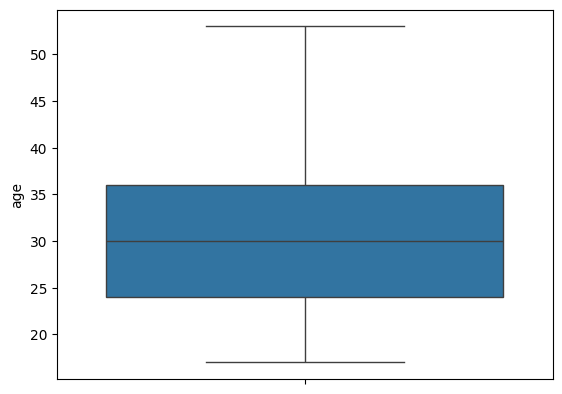

In [44]:
sns.boxplot(clean['age'])

#### Preprocessing

In [45]:
# -----------------Same prepocessing----------------------------#
target = "converted"
y = clean[target]
x = clean.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


#### Model training

In [46]:
# ----------------- model training for logistic regression ----------------------------#
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_baseline_age_clean": LogisticRegression(),
    }

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Logistic Regression_baseline_age_clean:
       Accuracy  Precision    Recall  F1-score
Train  0.986160   0.855853  0.689287  0.763592
Test   0.986172   0.873580  0.670665  0.758791




🔴 Cleaning didn't improve the recall and decreased the F1 score.

👍However, the precision is slightly better.



### 2.2. Feature engineering - polynomial variables

➡️ Let's try adding polynomial variables to see if the model performs better in a non-linear context.

In [47]:
df_train.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [48]:
# Adding non linear variables
numerical_features = ['age', 'total_pages_visited']
for col in numerical_features:
  df_train[f"{col} x2"] = df_train[col]**2
  df_train[f"{col} x3"] = df_train[col]**3
  df_train[f"{col} x4"] = df_train[col]**4
  df_train[f"{col} 1/x"] = 1/(df_train[col])
  df_train[f"{col} 1/x2"] = 1/(df_train[col]**2)
df_train.head()

,country,age,new_user,source,total_pages_visited,converted,age x2,age x3,age x4,age 1/x,age 1/x2,total_pages_visited x2,total_pages_visited x3,total_pages_visited x4,total_pages_visited 1/x,total_pages_visited 1/x2
0,China,22,1,Direct,2,0,484,10648,234256,0.045455,0.002066,4,8,16,0.500000,0.250000
1,UK,21,1,Ads,3,0,441,9261,194481,0.047619,0.002268,9,27,81,0.333333,0.111111
2,Germany,20,0,Seo,14,1,400,8000,160000,0.050000,0.002500,196,2744,38416,0.071429,0.005102
3,US,23,1,Seo,3,0,529,12167,279841,0.043478,0.001890,9,27,81,0.333333,0.111111
4,US,28,1,Direct,3,0,784,21952,614656,0.035714,0.001276,9,27,81,0.333333,0.111111


#### Preprocessing

In [49]:
# -----------------Same prepocessing----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited', 'age x2', 'age x3', 'age x4', 'age 1/x', 'age 1/x2', 'total_pages_visited x2', 'total_pages_visited x3', 'total_pages_visited x4', 'total_pages_visited 1/x', 'total_pages_visited 1/x2']
Found categorical features  ['country', 'new_user', 'source']


#### Model training

In [50]:
# -----------------model training on logistic regression----------------------------#
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_polynomial_features": LogisticRegression(),
    }

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Logistic Regression_polynomial_features:
       Accuracy  Precision    Recall  F1-score
Train   0.98621   0.853830  0.690753  0.763683
Test    0.98612   0.855782  0.685185  0.761041




🔴 We don't notice significant differences with the baseline model

### 2.3. Feature engineering interaction features




➡️ The feature total page visited seems to be hightly correlated to our target. let's try to build more features based on this one.

#### interaction features only

In [52]:
df_train = pd.read_csv(conversion_data_train)
df_train["ageXpage_visited"] = df_train["age"]*df_train["total_pages_visited"]
df_train["ageDIVpage_visited"] = df_train["age"]/df_train["total_pages_visited"]
df_train["page_visitedDIVage"] = df_train["total_pages_visited"]/df_train["age"]
df_train.head()

,country,age,new_user,source,total_pages_visited,converted,ageXpage_visited,ageDIVpage_visited,page_visitedDIVage
0,China,22,1,Direct,2,0,44,11.000000,0.090909
1,UK,21,1,Ads,3,0,63,7.000000,0.142857
2,Germany,20,0,Seo,14,1,280,1.428571,0.700000
3,US,23,1,Seo,3,0,69,7.666667,0.130435
4,US,28,1,Direct,3,0,84,9.333333,0.107143


##### Preprocessing

In [53]:
# -----------------Same prepocessing----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited', 'ageXpage_visited', 'ageDIVpage_visited', 'page_visitedDIVage']
Found categorical features  ['country', 'new_user', 'source']


##### Model training

In [54]:
# -----------------model training on logistic regression----------------------------#
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_interaction features": LogisticRegression(),
    }

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Logistic Regression_interaction features:
       Accuracy  Precision    Recall  F1-score
Train  0.986171   0.852765  0.690511  0.763109
Test   0.986085   0.853659  0.686275  0.760870




#### Interaction features + polynomials

In [55]:
numerical_features = ['age', 'total_pages_visited']
for col in numerical_features:
  df_train[f"{col} x2"] = df_train[col]**2
  df_train[f"{col} x3"] = df_train[col]**3
  df_train[f"{col} x4"] = df_train[col]**4
  df_train[f"{col} 1/x"] = 1/(df_train[col])
  df_train[f"{col} 1/x2"] = 1/(df_train[col]**2)

df_train["ageXpage_visited"] = df_train["age"]*df_train["total_pages_visited"]
df_train["ageDIVpage_visited"] = df_train["age"]/df_train["total_pages_visited"]
df_train["page_visitedDIVage"] = df_train["total_pages_visited"]/df_train["age"]

df_train.head()


,country,age,new_user,source,total_pages_visited,converted,ageXpage_visited,ageDIVpage_visited,page_visitedDIVage,age x2,age x3,age x4,age 1/x,age 1/x2,total_pages_visited x2,total_pages_visited x3,total_pages_visited x4,total_pages_visited 1/x,total_pages_visited 1/x2
0,China,22,1,Direct,2,0,44,11.000000,0.090909,484,10648,234256,0.045455,0.002066,4,8,16,0.500000,0.250000
1,UK,21,1,Ads,3,0,63,7.000000,0.142857,441,9261,194481,0.047619,0.002268,9,27,81,0.333333,0.111111
2,Germany,20,0,Seo,14,1,280,1.428571,0.700000,400,8000,160000,0.050000,0.002500,196,2744,38416,0.071429,0.005102
3,US,23,1,Seo,3,0,69,7.666667,0.130435,529,12167,279841,0.043478,0.001890,9,27,81,0.333333,0.111111
4,US,28,1,Direct,3,0,84,9.333333,0.107143,784,21952,614656,0.035714,0.001276,9,27,81,0.333333,0.111111


##### Preprocessing

In [56]:
# -----------------Same prepocessing----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited', 'ageXpage_visited', 'ageDIVpage_visited', 'page_visitedDIVage', 'age x2', 'age x3', 'age x4', 'age 1/x', 'age 1/x2', 'total_pages_visited x2', 'total_pages_visited x3', 'total_pages_visited x4', 'total_pages_visited 1/x', 'total_pages_visited 1/x2']
Found categorical features  ['country', 'new_user', 'source']


##### Model training

In [57]:
# -----------------model training on logistic regression----------------------------#
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_polynomial_interaction_features": LogisticRegression(),
    }

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Logistic Regression_polynomial_interaction_features:
       Accuracy  Precision    Recall  F1-score
Train  0.986237   0.855044  0.690390  0.763946
Test   0.986050   0.852503  0.686275  0.760410




🔴 The feature engineering with polynomial variables or with interaction between variables didn't improve the recall or the F1.
➡️ Let's try keeping only features with higher coefficients:

### 2.4. Feature selection


#### Visualization

In [58]:
one_hot_feature_names = featureencoder.named_transformers_['cat'].get_feature_names_out(categorical_features)
scaled_feature_names = numerical_features

# Combiner les noms des colonnes
feature_names = list(one_hot_feature_names) + scaled_feature_names

feature_importance = (pd.DataFrame({
    'Feature': feature_names,
    'Coef': model.coef_[0]})
).sort_values(by='Coef', ascending=False, key=abs)
feature_importance

,Feature,Coef
0,country_Germany,3.558695
1,country_UK,3.304905
2,country_US,2.966027
3,new_user_1,-1.684196
7,total_pages_visited,0.989127
13,age x4,0.645370
11,age x2,-0.644701
8,ageXpage_visited,0.613975
6,age,-0.592747
16,total_pages_visited x2,0.581826


In [60]:
df_train.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted', 'ageXpage_visited', 'ageDIVpage_visited',
       'page_visitedDIVage', 'age x2', 'age x3', 'age x4', 'age 1/x',
       'age 1/x2', 'total_pages_visited x2', 'total_pages_visited x3',
       'total_pages_visited x4', 'total_pages_visited 1/x',
       'total_pages_visited 1/x2'],
      dtype='object')

In [61]:
features_to_remove = ['source','total_pages_visited x3','age 1/x','total_pages_visited 1/x2','ageDIVpage_visited','total_pages_visited x4','total_pages_visited 1/x','age 1/x2','age x3']

df_train = df_train.drop(columns=features_to_remove)
df_train.columns

Index(['country', 'age', 'new_user', 'total_pages_visited', 'converted',
       'ageXpage_visited', 'page_visitedDIVage', 'age x2', 'age x4',
       'total_pages_visited x2'],
      dtype='object')

#### Preprocessing

In [62]:
# -----------------Same prepocessing----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited', 'ageXpage_visited', 'page_visitedDIVage', 'age x2', 'age x4', 'total_pages_visited x2']
Found categorical features  ['country', 'new_user']


#### Model training

In [63]:
# -----------------model training on logistic regression----------------------------#
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_best_features": LogisticRegression(),
    }

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Logistic Regression_best_features:
       Accuracy  Precision    Recall  F1-score
Train  0.986120   0.853113  0.688211  0.761841
Test   0.986014   0.852304  0.685185  0.759662




🔴 Still no improvement in the F1 score. To keep the model simple, we will keep the features unchanged.

In [64]:
df_train.columns

Index(['country', 'age', 'new_user', 'total_pages_visited', 'converted',
       'ageXpage_visited', 'page_visitedDIVage', 'age x2', 'age x4',
       'total_pages_visited x2'],
      dtype='object')

In [65]:
df_train = pd.read_csv(conversion_data_train)
df_train.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

## 3. Optimising the classification threshold

➡️ By ajusting the threshold in our logistic regression, we can hope improving the model's result. Let's try it.

### Preprocessing and threshold identification

In [66]:
#--------------Re-load the baseline model with same preprocessing -------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)
print()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression": LogisticRegression()
}

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']

Metrics for Logistic Regression:
       Accuracy  Precision    Recall  F1-score
Train  0.986245   0.855088  0.690632  0.764111
Test   0.986085   0.856557  0.683007  0.760000




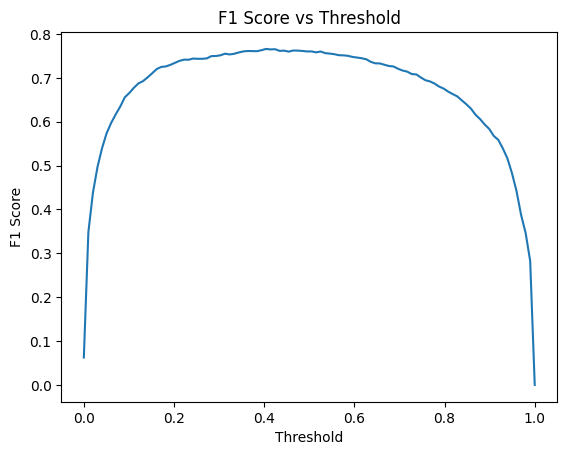

Optimal Threshold: 0.4040404040404041


In [67]:
# Look for optimal threshold for a highest F1 score
thresholds = np.linspace(0, 1, 100)
y_scores = model.predict_proba(x_test)[:, 1] # predictions for converted = 1
f1_scores = [f1_score(y_test, y_scores >= t) for t in thresholds]

# Identify the optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# plot F1 score with different threshold
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()

print(f"Optimal Threshold: {optimal_threshold}")


### Model training

In [68]:
 # -------------- Get the metrics with defined threshold ------------#
 # Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_optimal_threshold": LogisticRegression(),
}

# Define the thresholds to test ()
thresholds =   [0.38, 0.40, 0.42, 0.45, 0.47]

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)

    # Iterate over each threshold
    for threshold in thresholds:
        y_train_pred = (model.predict_proba(x_train)[:, 1] >= threshold).astype(int)
        y_test_pred = (model.predict_proba(x_test)[:, 1] >= threshold).astype(int)

        # Calculate metrics
        metrics_train = classification_metrics(y_train, y_train_pred)
        metrics_test = classification_metrics(y_test, y_test_pred)

        # Store metrics for each set (Train and Test)
        metrics_list = []
        for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
            metrics_list.append({
                "Model": f"{model_name}_{threshold}",
                "Set": set_type,
                **set_metrics
            })

        # Convert the metrics list to a DataFrame
        metrics_df = pd.DataFrame(metrics_list)

        # Append the DataFrame to the CSV file
        with open(csv_file_path, 'a') as f:
            metrics_df.to_csv(f, header=f.tell()==0, index=False)

        # Create a DataFrame for the model's metrics and print it
        print(f"Metrics for {model_name} at {threshold}:")
        model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
        print(model_metrics_df)
        print("\n")


Metrics for Logistic Regression_optimal_threshold at 0.38:
       Accuracy  Precision    Recall  F1-score
Train  0.985690   0.798778  0.743767  0.770291
Test   0.985031   0.786713  0.735294  0.760135


Metrics for Logistic Regression_optimal_threshold at 0.4:
       Accuracy  Precision    Recall  F1-score
Train  0.985929   0.809378  0.737473  0.771754
Test   0.985312   0.797619  0.729847  0.762230


Metrics for Logistic Regression_optimal_threshold at 0.42:
       Accuracy  Precision    Recall  F1-score
Train  0.985991   0.819001  0.726216  0.769823
Test   0.985733   0.816832  0.718954  0.764774


Metrics for Logistic Regression_optimal_threshold at 0.45:
       Accuracy  Precision    Recall  F1-score
Train  0.986233   0.834652  0.714839  0.770113
Test   0.985804   0.831186  0.702614  0.761511


Metrics for Logistic Regression_optimal_threshold at 0.47:
       Accuracy  Precision    Recall  F1-score
Train  0.986225   0.842349  0.704914  0.767528
Test   0.986014   0.842105  0.697168  0.

✅ Yeah!! the Recall finaly got better without impacting too much the Precision ! With a threshold at 0.42, we reach the highest F1 score so far on test set. By slightly increasing or decreasing the threshold, we can favorize Recall or Precision depending on the business priorities.  
➡️ Let's try to improve F1 again with no linear models.

## 4. Non lineare models

### 4.1. Decision tree and Random Forest

➡️ Decision tree is an non linear model that consists of nodes representing decisions or features, branches representing outcomes, and leaves representing final decisions or classifications. In a classification problem, the final outcome of the decision tree is the class label that is most common among the samples in the leaf node.  

➡️ Random Forest is an ensemble learning method that operates by constructing multiple decision trees (called estimators) during training.
The final outcome of a Random Forest is determined by aggregating the predictions of all the individual trees. For classification tasks, this is typically done by majority voting (the class that is predicted most frequently across all trees).

#### Preprocessing

In [69]:
# ----------------- Adjust prepocessing for non linear models ----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder() # No drop first needed

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


#### Optuna study

In [ ]:
def objective(trial):

    # Define the model type
    model_type = trial.suggest_categorical('model_type', ['RandomForest', 'DecisionTree'])

    if model_type == 'RandomForest':
        # Define hyperparameters for Random Forest
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    else:
        # Define hyperparameters for Decision Tree
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)

    # Train the model
    model.fit(x_train, y_train)

    # Predict and calculate F1 score
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



[I 2025-05-26 14:43:19,343] A new study created in memory with name: no-name-e595ce20-9d79-448e-ba39-0aa23da4df42
[I 2025-05-26 14:43:19,796] Trial 0 finished with value: 0.9847687039128943 and parameters: {'model_type': 'DecisionTree', 'max_depth': 6, 'min_samples_split': 20}. Best is trial 0 with value: 0.9847687039128943.
[I 2025-05-26 14:43:38,939] Trial 1 finished with value: 0.9843090714402509 and parameters: {'model_type': 'RandomForest', 'n_estimators': 108, 'max_depth': 12}. Best is trial 0 with value: 0.9847687039128943.
[I 2025-05-26 14:43:54,540] Trial 2 finished with value: 0.9761277914536284 and parameters: {'model_type': 'RandomForest', 'n_estimators': 186, 'max_depth': 3}. Best is trial 0 with value: 0.9847687039128943.
[I 2025-05-26 14:43:54,725] Trial 3 finished with value: 0.9792803738487218 and parameters: {'model_type': 'DecisionTree', 'max_depth': 2, 'min_samples_split': 6}. Best is trial 0 with value: 0.9847687039128943.
[I 2025-05-26 14:43:55,316] Trial 4 finish

Best trial:
  F1 Score: 0.9853292902088236
  Params: 
    model_type: RandomForest
    n_estimators: 199
    max_depth: 6


#### Model training

In [70]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Best parameters from Optuna study
best_params = {
    "model_type": "RandomForest",
    "n_estimators": 199,
    "max_depth": 6
}

# Initialize the best model with the best parameters
best_model = RandomForestClassifier(n_estimators=best_params["n_estimators"],
                                    max_depth=best_params["max_depth"],
                                    random_state=42)

models = {
    "Random Forest optuna": best_model
}

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Random Forest optuna
       Accuracy  Precision    Recall  F1-score
Train  0.986003   0.860713  0.675381  0.756867
Test   0.986190   0.870240  0.672113  0.758451




🔴No better score found with Random Forest or Decision Trees.   
➡️ But let's try with more estimators since the chosen estimator is near the given limit and with defining a min sample split.

#### Optuna study 2

In [ ]:
def objective(trial):
    # Define hyperparameters for Random Forest
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Initialize the Random Forest model with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Train the model
    model.fit(x_train, y_train)

    # Predict and calculate F1 score
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-27 09:26:37,322] A new study created in memory with name: no-name-3db76ca0-9d12-44a4-89fe-2a0af43d2bbb
[I 2025-05-27 09:27:14,958] Trial 0 finished with value: 0.9851103002578739 and parameters: {'n_estimators': 248, 'max_depth': 10, 'min_samples_split': 4}. Best is trial 0 with value: 0.9851103002578739.
[I 2025-05-27 09:27:28,135] Trial 1 finished with value: 0.9518773135906928 and parameters: {'n_estimators': 212, 'max_depth': 2, 'min_samples_split': 8}. Best is trial 0 with value: 0.9851103002578739.
[I 2025-05-27 09:27:42,150] Trial 2 finished with value: 0.9518773135906928 and parameters: {'n_estimators': 224, 'max_depth': 2, 'min_samples_split': 10}. Best is trial 0 with value: 0.9851103002578739.
[I 2025-05-27 09:27:52,579] Trial 3 finished with value: 0.9518773135906928 and parameters: {'n_estimators': 161, 'max_depth': 2, 'min_samples_split': 4}. Best is trial 0 with value: 0.9851103002578739.
[I 2025-05-27 09:28:26,981] Trial 4 finished with value: 0.9851383955654

Best trial:
  F1 Score: 0.9853329807753061
  Params: 
    n_estimators: 274
    max_depth: 7
    min_samples_split: 4


#### Model training

In [71]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Best parameters from Optuna study
best_params = {
    "n_estimators": 274,
    "max_depth": 7,
    "min_samples_split" : 4
}

# Initialize the best model with the best parameters
best_model = RandomForestClassifier(n_estimators=best_params["n_estimators"],
                                    max_depth=best_params["max_depth"],
                                    min_samples_split=best_params["min_samples_split"],
                                    random_state=42)

models = {
    "Random Forest optuna2": best_model
}

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Random Forest optuna2
       Accuracy  Precision    Recall  F1-score
Train  0.986335   0.860321  0.688090  0.764627
Test   0.986085   0.855586  0.684096  0.760291




✅🔴 With more estimators, the random forest model get a little bit better regarding to the F1 score and the Precision despite a low Recall. However, it's not as good as the logistic regression with threshold at 0.42.  

### 4.2. Usage of Optuna to Optimize again Logistic regression

➡️  Maybe the logistic resgression can be more optimized thanks to Optuna

#### Preprocessing

In [72]:
# ----------------- Adjust prepocessing for non linear models ----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder() # No drop first needed

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


#### Optuna study

In [37]:
def objective(trial):
    # Define hyperparameters for Logistic Regression
    C = trial.suggest_float('C', 0.01, 10, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear'])  # 'liblinear' works well with both L1 and L2 penalties

    # Initialize the Logistic Regression model with the suggested hyperparameters
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        random_state=42
    )

    # Train the model
    model.fit(x_train, y_train)

    # Predict and calculate F1 score
    y_pred = (model.predict_proba(x_test)[:, 1] >= 0.4).astype(int)  # Use the threshold of 0.4
    f1 = f1_score(y_test, y_pred)

    return f1

# Create a study to maximize the F1 score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-05-27 14:23:23,155] A new study created in memory with name: no-name-872cba66-374c-4658-a6f2-1be025f8dc2d
[I 2025-05-27 14:23:23,773] Trial 0 finished with value: 0.7606290040768783 and parameters: {'C': 0.015743024131796915, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7606290040768783.
[I 2025-05-27 14:23:48,166] Trial 1 finished with value: 0.7651083238312428 and parameters: {'C': 0.22130873565059445, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7651083238312428.
[I 2025-05-27 14:23:49,027] Trial 2 finished with value: 0.7639930755914599 and parameters: {'C': 0.02527556064667515, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7651083238312428.
[I 2025-05-27 14:23:53,546] Trial 3 finished with value: 0.7635947338294219 and parameters: {'C': 0.028505284412622504, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.7651083238312428.
[I 2025-05-27 14:23:54,424] Trial 4 finished with va

Best trial:
  F1 Score: 0.7672018348623854
  Params: 
    C: 0.049972445971045346
    penalty: l2
    solver: liblinear


#### Model training

In [73]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Best parameters from Optuna study
best_params = {
    "C": 0.049972445971045346,
    "penalty": "l2",
    "solver": "liblinear"
}

# Initialize the best model with the best parameters
best_model = LogisticRegression(
    C=best_params["C"],
    penalty=best_params["penalty"],
    solver=best_params["solver"],
    random_state=42
)

models = {
    "Logistic Regression Optuna": best_model
}

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for Logistic Regression Optuna
       Accuracy  Precision    Recall  F1-score
Train  0.986218   0.859356  0.684822  0.762226
Test   0.985979   0.857931  0.677560  0.757152




🔴 No better score found.

### 4.3. Support Vector Machine model

➡️ Support Vector Machine (SVM) is a type of supervised learning algorithm particularly good at solving binary classification problems. Indeed, **it can handle both linearly separable and non-linearly separable data by using different types of kernel functions** (such as linear kernel, polynomial kernel or radial basis function (RBF) kernel). These kernels enable SVMs to effectively capture complex relationships and patterns in the data. For these reasons, it may be worth a try for our challenge !

⚠️However, as it can be particularly long to train, we will make Optuna train on only 30 trials.

#### Optuna study

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.metrics import f1_score

def objective(trial):
    # Define hyperparameters for SVM with reduced options
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    C = trial.suggest_float('C', 0.1, 10, log=True)

    # Define gamma
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  # Always define gamma

    # Initialize the SVM model with the suggested hyperparameters
    model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        random_state=42
    )

    # Train the model
    model.fit(x_train, y_train)

    # Predict and calculate F1 score
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return f1

# Create a study to maximize the F1 score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Further reduced number of trials

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-05-26 15:58:21,594] A new study created in memory with name: no-name-b7809093-64bd-43bb-85b4-6556090692f7
[I 2025-05-26 16:07:05,913] Trial 0 finished with value: 0.9847496172589544 and parameters: {'kernel': 'rbf', 'C': 1.1915811303411243, 'gamma': 'auto'}. Best is trial 0 with value: 0.9847496172589544.
[I 2025-05-26 16:16:57,650] Trial 1 finished with value: 0.9847067120085359 and parameters: {'kernel': 'rbf', 'C': 0.8704012182480202, 'gamma': 'auto'}. Best is trial 0 with value: 0.9847496172589544.
[I 2025-05-26 16:19:14,927] Trial 2 finished with value: 0.9851755627685413 and parameters: {'kernel': 'linear', 'C': 0.7220539056109383, 'gamma': 'scale'}. Best is trial 2 with value: 0.9851755627685413.
[I 2025-05-26 16:28:04,219] Trial 3 finished with value: 0.9847496172589544 and parameters: {'kernel': 'rbf', 'C': 1.1722670363376462, 'gamma': 'auto'}. Best is trial 2 with value: 0.9851755627685413.
[I 2025-05-26 16:31:16,438] Trial 4 finished with value: 0.98524536228826 and 

Best trial:
  F1 Score: 0.9853104682014673
  Params: 
    kernel: linear
    C: 7.519968140313692
    gamma: auto


#### Model training

In [74]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Best parameters from Optuna study
best_params = {
    "model_type": "SVC",
    "kernel": "linear",
    "C": 7.519968140313692,
    "gamma": "auto"
}

# Initialize the best model with the best parameters
best_model = SVC(
    kernel=best_params["kernel"],
    C=best_params["C"],
    gamma=best_params["gamma"],
    random_state=42
)

models = {
    "SVC optuna": best_model
}

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for SVC optuna
       Accuracy  Precision    Recall  F1-score
Train  0.986155   0.862101  0.679496  0.759984
Test   0.986120   0.862691  0.677560  0.758999




🔴 Using SVM did not improve the F1 score.   
✅ However, it did result in a slight improvement in precision, although recall was degraded.

### 4.4. Adaboost

➡️ AdaBoost, short for Adaptive Boosting, is a machine learning algorithm used primarily for classification tasks. It is an ensemble learning method that combines multiple weak learners to create a strong classifier. The concept of boosting involves sequentially training models, where each new model focuses on correcting the errors made by the previous ones.

#### Preprocessing

In [75]:
# ----------------- Adjust prepocessing for non linear models ----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder() # No drop first needed

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


#### Optuna study

In [76]:
def objective(trial):
    # Define hyperparameters for AdaBoost
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)

    # Initialize the base estimator (Decision Tree)
    base_estimator = DecisionTreeClassifier(max_depth=1)

    # Initialize the AdaBoost model with the suggested hyperparameters
    model = AdaBoostClassifier(
        estimator=base_estimator,  # Use 'estimator' instead of 'base_estimator'
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    # Train the model
    model.fit(x_train, y_train)

    # Predict and calculate F1 score
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)

    return f1

# Create a study to maximize the F1 score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-28 10:11:16,286] A new study created in memory with name: no-name-9250739e-2fb3-43ae-b7d0-2bb39ae27757
[I 2025-05-28 10:11:41,357] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 180, 'learning_rate': 0.013659255285697114}. Best is trial 0 with value: 0.0.
[I 2025-05-28 10:12:02,645] Trial 1 finished with value: 0.7303102625298329 and parameters: {'n_estimators': 158, 'learning_rate': 0.5131350388288932}. Best is trial 1 with value: 0.7303102625298329.
[I 2025-05-28 10:12:18,412] Trial 2 finished with value: 0.677195198989261 and parameters: {'n_estimators': 115, 'learning_rate': 0.01141110734517761}. Best is trial 1 with value: 0.7303102625298329.
[I 2025-05-28 10:12:40,082] Trial 3 finished with value: 0.7383685800604229 and parameters: {'n_estimators': 152, 'learning_rate': 0.3291251869389139}. Best is trial 3 with value: 0.7383685800604229.
[I 2025-05-28 10:13:01,159] Trial 4 finished with value: 0.7270574304322084 and parameters: {'n_estimators': 148, 

Best trial:
  F1 Score: 0.7532149418248623
  Params: 
    n_estimators: 274
    learning_rate: 0.998784260843801


#### Model training

In [77]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=274,
        learning_rate=0.998784260843801,
        random_state=42
    )
}

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")

Metrics for AdaBoost:
       Accuracy  Precision    Recall  F1-score
Train  0.985667   0.848913  0.675986  0.752645
Test   0.985839   0.860140  0.669935  0.753215




🔴 No improvement noted with Adaboost

### 4.5. XGBoost

➡️ XGBoost, or Extreme Gradient Boosting, is a powerful machine learning algorithm used for supervised learning tasks like classification and regression. It builds upon the concept of gradient boosting, where models are added sequentially to correct errors made by previous models. It includes features like regularization to prevent overfitting and supports parallel processing for faster training.

#### Preprocessing

In [78]:
# ----------------- Adjust prepocessing for non linear models ----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder() # No drop first needed

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


#### Optuna study

In [ ]:
def objective(trial):
    # Define hyperparameters for XGBoost
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }

    # Initialize the XGBoost model with the suggested hyperparameters
    model = xgb.XGBClassifier(**params)

    # Train the model
    model.fit(x_train, y_train)

    # Predict and calculate F1 score
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)

    return f1

# Create a study to maximize the F1 score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Number of trials

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-05-26 19:45:11,100] A new study created in memory with name: no-name-7e23eec1-4003-49b3-9048-cbb4fa8e15ef
[I 2025-05-26 19:45:17,314] Trial 0 finished with value: 0.7352062163777645 and parameters: {'max_depth': 10, 'min_child_weight': 1.5360843633170256, 'n_estimators': 114, 'subsample': 0.7427375827669072}. Best is trial 0 with value: 0.7352062163777645.
[I 2025-05-26 19:45:18,525] Trial 1 finished with value: 0.7584134615384616 and parameters: {'max_depth': 4, 'min_child_weight': 6.148483471171035, 'n_estimators': 65, 'subsample': 0.8012690442103532}. Best is trial 1 with value: 0.7584134615384616.
[I 2025-05-26 19:45:23,029] Trial 2 finished with value: 0.7383512544802867 and parameters: {'max_depth': 8, 'min_child_weight': 1.464646869679139, 'n_estimators': 170, 'subsample': 0.8369604144175269}. Best is trial 1 with value: 0.7584134615384616.
[I 2025-05-26 19:45:28,508] Trial 3 finished with value: 0.7528562838244137 and parameters: {'max_depth': 5, 'min_child_weight': 8.6

Best trial:
  F1 Score: 0.7615062761506276
  Params: 
    max_depth: 5
    min_child_weight: 1.7968122321290716
    n_estimators: 55
    subsample: 0.7523602744569384


#### Model training

In [79]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Best parameters from Optuna study
best_params = {
    "model_type": "xgb.XGBClassifier",
    "max_depth": 5,
    "min_child_weight": 1.7968122321290716,
    "n_estimators": 55,
    "subsample": 0.7523602744569384
}

# Initialize the best model with the best parameters
best_model = xgb.XGBClassifier(
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    n_estimators=best_params["n_estimators"],
    subsample=best_params["subsample"],
    random_state=42
)

models = {
    "xgb.XGBClassifier optuna": best_model
}

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for xgb.XGBClassifier optuna
       Accuracy  Precision    Recall  F1-score
Train  0.986530   0.852166  0.704672  0.771432
Test   0.985979   0.843709  0.693900  0.761506




✅ XGBoost gave slightly better restults on F1 score but Recall is impacted.

### 4.6. GradientBoostingClassifier

➡️ GradientBoostingClassifier is very similar to the XGBoost model from the sklearn library but does not have the same level of optimization and parallel processing capabilities. In fact, it can be slower and less performant on complex datasets. However, since our dataset is quite simple, doesn't have missing values, and doesn't seem very sensitive to overfitting, it can be worth a try!

#### Optuna study

In [ ]:
def objective(trial):
    # Define hyperparameters for GradientBoostingClassifier
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }

    # Initialize the GradientBoostingClassifier model with the suggested hyperparameters
    model = GradientBoostingClassifier(**params)

    # Train the model
    model.fit(x_train, y_train)

    # Predict and calculate F1 score
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)

    return f1

# Create a study to maximize the F1 score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Number of trials

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  F1 Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-05-26 19:54:51,078] A new study created in memory with name: no-name-c56071f9-9e0a-4eb9-a646-4a6f2ae43342
[I 2025-05-26 19:55:33,665] Trial 0 finished with value: 0.7502986857825568 and parameters: {'n_estimators': 127, 'learning_rate': 0.08054079768986994, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2', 'subsample': 0.9653446755070616}. Best is trial 0 with value: 0.7502986857825568.
[I 2025-05-26 19:57:03,608] Trial 1 finished with value: 0.7505966587112172 and parameters: {'n_estimators': 145, 'learning_rate': 0.022178909101799957, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'subsample': 0.8747817572227562}. Best is trial 1 with value: 0.7505966587112172.
[I 2025-05-26 19:57:22,301] Trial 2 finished with value: 0.7557160048134778 and parameters: {'n_estimators': 112, 'learning_rate': 0.163225798993643, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'log2', 'sub

Best trial:
  F1 Score: 0.7619617224880383
  Params: 
    n_estimators: 82
    learning_rate: 0.07124824492043452
    max_depth: 3
    min_samples_split: 7
    min_samples_leaf: 8
    max_features: None
    subsample: 0.9967652157700437


#### Model training

In [80]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Best parameters from Optuna study
best_params = {
    'n_estimators': 82,
        'learning_rate': 0.07124824492043452,
        'max_depth': 3,
        'min_samples_split': 7,
        'min_samples_leaf': 8,
        'max_features': None,
        'subsample': 0.9967652157700437
}

# Initialize the best model with the best parameters
best_model = GradientBoostingClassifier(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    subsample=best_params["subsample"],
    random_state=42
)

models = {
    "GradientBoostingClassifier optuna": best_model
}

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)

    # Predictions
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for GradientBoostingClassifier optuna
       Accuracy  Precision    Recall  F1-score
Train  0.986178   0.845075  0.699831  0.765625
Test   0.986014   0.844828  0.693900  0.761962






🔴 GuardianBoostingClassifier gave worst scores than XGBoost.

## 5. Choosing the best of each model

In [82]:
# Load the metrics DataFrame
df_metrics = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv")

pd.set_option('display.max_colwidth', 100)

# Sort the DataFrame by "F1-score" in descending order
df_metrics = df_metrics.sort_values(by="F1-score", ascending=False)
df_metrics[df_metrics["Set"]=="Test"].head(10)

,Model,Set,Accuracy,Precision,Recall,F1-score
23,Logistic Regression_optimal_threshold_0.42,Test,0.985733,0.816832,0.718954,0.764774
27,Logistic Regression_optimal_threshold_0.47,Test,0.986014,0.842105,0.697168,0.762813
21,Logistic Regression_optimal_threshold_0.4,Test,0.985312,0.797619,0.729847,0.762230
41,GradientBoostingClassifier optuna,Test,0.986014,0.844828,0.693900,0.761962
25,Logistic Regression_optimal_threshold_0.45,Test,0.985804,0.831186,0.702614,0.761511
39,xgb.XGBClassifier optuna,Test,0.985979,0.843709,0.693900,0.761506
5,Logistic Regression_baseline_newusers_num,Test,0.986120,0.855782,0.685185,0.761041
11,Logistic Regression_polynomial_features,Test,0.986120,0.855782,0.685185,0.761041
13,Logistic Regression_interaction features,Test,0.986085,0.853659,0.686275,0.760870
15,Logistic Regression_polynomial_interaction_features,Test,0.986050,0.852503,0.686275,0.760410


➡️ Among all models tested, best F1-score on test set have been found in :
- Logistic Regression with different Threshold,
- GuardianBoostingClassifier,
- xgb.XGBClassifier
- Logistic Regression (baseline) with new interactive features,


First, we can try theses models with the interactive features to see if any improvement is noted



### 5.1. Feature engineering - interactive features

In [83]:
df_train = pd.read_csv(conversion_data_train)
df_train["ageXpage_visited"] = df_train["age"]*df_train["total_pages_visited"]
df_train["ageDIVpage_visited"] = df_train["age"]/df_train["total_pages_visited"]
df_train["page_visitedDIVage"] = df_train["total_pages_visited"]/df_train["age"]
df_train.head()

,country,age,new_user,source,total_pages_visited,converted,ageXpage_visited,ageDIVpage_visited,page_visitedDIVage
0,China,22,1,Direct,2,0,44,11.000000,0.090909
1,UK,21,1,Ads,3,0,63,7.000000,0.142857
2,Germany,20,0,Seo,14,1,280,1.428571,0.700000
3,US,23,1,Seo,3,0,69,7.666667,0.130435
4,US,28,1,Direct,3,0,84,9.333333,0.107143


#### 5.1.1. Feature engineering for Logistic Regression

##### Preprocessing

In [84]:
# -----------------prepocessing for linear models----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited', 'ageXpage_visited', 'ageDIVpage_visited', 'page_visitedDIVage']
Found categorical features  ['country', 'new_user', 'source']


##### Model training

In [85]:
 # -------------- Get the metrics with defined threshold ------------#
 # Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the models
models = {
    "Logistic Regression_interaction_features": LogisticRegression(),
}

# Define the thresholds to test ()
thresholds =   [0.38, 0.40, 0.42, 0.45, 0.47]

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)

    # Iterate over each threshold
    for threshold in thresholds:
        y_train_pred = (model.predict_proba(x_train)[:, 1] >= threshold).astype(int)
        y_test_pred = (model.predict_proba(x_test)[:, 1] >= threshold).astype(int)

        # Calculate metrics
        metrics_train = classification_metrics(y_train, y_train_pred)
        metrics_test = classification_metrics(y_test, y_test_pred)

        # Store metrics for each set (Train and Test)
        metrics_list = []
        for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
            metrics_list.append({
                "Model": f"{model_name}_threshold: {threshold}",
                "Set": set_type,
                **set_metrics
            })

        # Convert the metrics list to a DataFrame
        metrics_df = pd.DataFrame(metrics_list)

        # Append the DataFrame to the CSV file
        with open(csv_file_path, 'a') as f:
            metrics_df.to_csv(f, header=f.tell()==0, index=False)

        # Create a DataFrame for the model's metrics and print it
        print(f"Metrics for {model_name} with Threshold {threshold}:")
        model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
        print(model_metrics_df)
        print("\n")


Metrics for Logistic Regression_interaction_features with Threshold 0.38:
       Accuracy  Precision    Recall  F1-score
Train  0.985573   0.796059  0.743161  0.768701
Test   0.985171   0.789044  0.737473  0.762387


Metrics for Logistic Regression_interaction_features with Threshold 0.4:
       Accuracy  Precision    Recall  F1-score
Train  0.985854   0.808239  0.736141  0.770507
Test   0.985382   0.799523  0.729847  0.763098


Metrics for Logistic Regression_interaction_features with Threshold 0.42:
       Accuracy  Precision    Recall  F1-score
Train  0.985979    0.81728  0.728153  0.770147
Test   0.985558    0.81335  0.716776  0.762015


Metrics for Logistic Regression_interaction_features with Threshold 0.45:
       Accuracy  Precision    Recall  F1-score
Train  0.986120   0.831339  0.714718  0.768630
Test   0.985839   0.831403  0.703704  0.762242


Metrics for Logistic Regression_interaction_features with Threshold 0.47:
       Accuracy  Precision    Recall  F1-score
Train  0.986

#### 5.1.2. Feature engineering for non linear models

###### Preprocessing

In [86]:
# ----------------- Adjust prepocessing for non linear models ----------------------------#
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder() # No drop first needed

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited', 'ageXpage_visited', 'ageDIVpage_visited', 'page_visitedDIVage']
Found categorical features  ['country', 'new_user', 'source']


##### Model training

In [87]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }


# Define the models
models = {
    "xgb.XGBClassifier_interactive_features": xgb.XGBClassifier(
        max_depth=5,
        min_child_weight=1.7968122321290716,
        n_estimators=55,
        subsample=0.7523602744569384,
        random_state=42),
    "GradientBoostingClassifier_interactive_features":GradientBoostingClassifier(
        n_estimators=82,
        learning_rate=0.07124824492043452,
        max_depth=3,
        min_samples_split=7,
        min_samples_leaf=8,
        max_features=None,
        subsample=0.9967652157700437,
        random_state=42)
    }

# Path to the CSV file
csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"

# Iterate over each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Calculate metrics
    metrics_train = classification_metrics(y_train, y_train_pred)
    metrics_test = classification_metrics(y_test, y_test_pred)

    # Store metrics for each set (Train and Test)
    metrics_list = []
    for set_type, set_metrics in {"Train": metrics_train, "Test": metrics_test}.items():
        metrics_list.append({
            "Model": model_name,
            "Set": set_type,
            **set_metrics
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Append the DataFrame to the CSV file
    with open(csv_file_path, 'a') as f:
        metrics_df.to_csv(f, header=f.tell()==0, index=False)

    # Create a DataFrame for the model's metrics and print it
    print(f"Metrics for {model_name}:")
    model_metrics_df = pd.DataFrame({"Train": metrics_train, "Test": metrics_test}).T
    print(model_metrics_df)
    print("\n")


Metrics for xgb.XGBClassifier_interactive_features:
       Accuracy  Precision    Recall  F1-score
Train  0.986545   0.855058  0.701888  0.770939
Test   0.985804   0.840849  0.690632  0.758373


Metrics for GradientBoostingClassifier_interactive_features:
       Accuracy  Precision    Recall  F1-score
Train  0.986112   0.832509  0.712902  0.768077
Test   0.985733   0.829897  0.701525  0.760331




#### Results

In [88]:
# Load the metrics DataFrame
df_metrics = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv")
pd.set_option('display.max_colwidth', 100)
# Sort the DataFrame by "F1-score" in descending order
df_metrics = df_metrics.sort_values(by="F1-score", ascending=False)
df_metrics[df_metrics["Set"]=="Test"].head(20)



,Model,Set,Accuracy,Precision,Recall,F1-score
23,Logistic Regression_optimal_threshold_0.42,Test,0.985733,0.816832,0.718954,0.764774
45,Logistic Regression_interaction_features_threshold: 0.4,Test,0.985382,0.799523,0.729847,0.763098
27,Logistic Regression_optimal_threshold_0.47,Test,0.986014,0.842105,0.697168,0.762813
43,Logistic Regression_interaction_features_threshold: 0.38,Test,0.985171,0.789044,0.737473,0.762387
49,Logistic Regression_interaction_features_threshold: 0.45,Test,0.985839,0.831403,0.703704,0.762242
21,Logistic Regression_optimal_threshold_0.4,Test,0.985312,0.797619,0.729847,0.762230
47,Logistic Regression_interaction_features_threshold: 0.42,Test,0.985558,0.813350,0.716776,0.762015
41,GradientBoostingClassifier optuna,Test,0.986014,0.844828,0.693900,0.761962
25,Logistic Regression_optimal_threshold_0.45,Test,0.985804,0.831186,0.702614,0.761511
39,xgb.XGBClassifier optuna,Test,0.985979,0.843709,0.693900,0.761506


🔴 Interactive features helped improving the model on Logistic Regression but without beating the higest score found so far. For non linear models, the feature engineering didn't allow any postive improvement.

In [89]:
df_train = pd.read_csv(conversion_data_train)
df_train.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

### 5.2. Voting

➡️ Let's try to get the best of each of our best models by the ensemble model of voting:

#### Preprocessing

In [90]:
# -----------------prepocessing for linear models----------------------------#
# as the only difference between linear and non linear models' preprocessing is the "drop first" in OneHotEncoder,
# to avoid Multi-colinearity we conserve the drop first argument.
target = "converted"
y = df_train[target]
x = df_train.drop(target, axis=1)

x['new_user'] = x['new_user'].astype(str) #to have new user considered as categorical variable

numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(include=object).columns.tolist()

print("Found numeric features ", numerical_features)
print("Found categorical features ", categorical_features)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify = y) # stratify to make sure that the proportions remain the same in both the train and test data

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop = 'first') # drop first to avoid Mutli-colinearity in linear models

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numerical_features)
        ]
    )

x_train = featureencoder.fit_transform(x_train)
x_test = featureencoder.transform(x_test)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


#### Model training

In [91]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the voting classifier function
def evaluate_voting_classifier(estimators, voting_type, x_train, y_train, x_test, y_test):
    model = VotingClassifier(estimators=estimators, voting=voting_type)
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    metrics = []
    for set_name, y_true, y_pred in [("Train", y_train, y_pred_train), ("Test", y_test, y_pred_test)]:
        metrics.append({
            "Model": f"VotingClassifier_{voting_type}",
            "Set": set_name,
            **classification_metrics(y_true, y_pred)
        })
    return metrics

# === Model Definitions ===

models = {
    "XGBClassifier": XGBClassifier(
        max_depth=5,
        min_child_weight=1.7968122321290716,
        n_estimators=55,
        subsample=0.7523602744569384,
        random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        n_estimators=82,
        learning_rate=0.07124824492043452,
        max_depth=3,
        min_samples_split=7,
        min_samples_leaf=8,
        max_features=None,
        subsample=0.9967652157700437,
        random_state=42),
    "LogisticRegression": LogisticRegression()
}

# === Main ===

csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"
estimators = list(models.items())
all_metrics = []

for voting_type in ["hard", "soft"]:
    metrics = evaluate_voting_classifier(estimators, voting_type, x_train, y_train, x_test, y_test)
    all_metrics.extend(metrics)

    # Print metrics
    print(f"Metrics for VotingClassifier_{voting_type}:")
    print(pd.DataFrame(metrics).set_index("Set"))
    print("\n")

# Save all metrics to CSV
metrics_df = pd.DataFrame(all_metrics)
with open(csv_file_path, 'a') as f:
    metrics_df.to_csv(f, header=f.tell() == 0, index=False)


Metrics for VotingClassifier_hard:
                       Model  Accuracy  Precision    Recall  F1-score
Set                                                                  
Train  VotingClassifier_hard  0.986323   0.855946  0.692568  0.765639
Test   VotingClassifier_hard  0.985804   0.847297  0.683007  0.756333


Metrics for VotingClassifier_soft:
                       Model  Accuracy  Precision    Recall  F1-score
Set                                                                  
Train  VotingClassifier_soft  0.986315   0.853365  0.695231  0.766224
Test   VotingClassifier_soft  0.985909   0.846980  0.687364  0.758870




✅ Soft voting works better than hard voting, but we still didn't beat our higest score.   
➡️ Let's try to ajust the models weights giving a higher weight to our best model.

#### Model training with weights

In [93]:
# Define the classification metrics function
def classification_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Define the voting classifier function
def evaluate_voting_classifier(estimators, weights, x_train, y_train, x_test, y_test):
    model = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    metrics = []
    for set_name, y_true, y_pred in [("Train", y_train, y_pred_train), ("Test", y_test, y_pred_test)]:
        metrics.append({
            "Model": f"VotingClassifier_soft_weights_{weights}",
            "Set": set_name,
            **classification_metrics(y_true, y_pred)
        })
    return metrics

# === Model Definitions ===

models = {
    "XGBClassifier": XGBClassifier(
        max_depth=5,
        min_child_weight=1.7968122321290716,
        n_estimators=55,
        subsample=0.7523602744569384,
        random_state=42),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        n_estimators=82,
        learning_rate=0.07124824492043452,
        max_depth=3,
        min_samples_split=7,
        min_samples_leaf=8,
        max_features=None,
        subsample=0.9967652157700437,
        random_state=42),
    "LogisticRegression": LogisticRegression()
}

# === Main ===

csv_file_path = "/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv"
estimators = list(models.items())
all_metrics = []

# Define the weights to test
weights_list = [[1, 1, 2], [1, 2, 3], [2, 1, 3], [1, 1, 3]]

for weights in weights_list:
    metrics = evaluate_voting_classifier(estimators, weights, x_train, y_train, x_test, y_test)
    all_metrics.extend(metrics)

    # Print metrics
    print(f"Metrics for VotingClassifier_soft with weights {weights}:")
    print(pd.DataFrame(metrics).set_index("Set"))
    print("\n")

# Save all metrics to CSV
metrics_df = pd.DataFrame(all_metrics)
with open(csv_file_path, 'a') as f:
    metrics_df.to_csv(f, header=f.tell() == 0, index=False)


Metrics for VotingClassifier_soft with weights [1, 1, 2]:
                                         Model  Accuracy  Precision    Recall  \
Set                                                                             
Train  VotingClassifier_soft_weights_[1, 1, 2]  0.986303   0.854564  0.693416   
Test   VotingClassifier_soft_weights_[1, 1, 2]  0.985944   0.848118  0.687364   

       F1-score  
Set              
Train  0.765602  
Test   0.759326  


Metrics for VotingClassifier_soft with weights [1, 2, 3]:
                                         Model  Accuracy  Precision    Recall  \
Set                                                                             
Train  VotingClassifier_soft_weights_[1, 2, 3]  0.986284   0.855092  0.692084   
Test   VotingClassifier_soft_weights_[1, 2, 3]  0.985944   0.848118  0.687364   

       F1-score  
Set              
Train  0.765001  
Test   0.759326  


Metrics for VotingClassifier_soft with weights [2, 1, 3]:
                            

🔴 We don't notice significant differences between the different weights tested, and no model showed better scores than those already achieved.

# Part 3: Final results

In [95]:
# Load the metrics DataFrame
df_metrics = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Jedha/Supervised ML/model_metrics.csv")
pd.set_option('display.max_colwidth', 100)
# Sort the DataFrame by "F1-score" in descending order
df_metrics = df_metrics.sort_values(by="F1-score", ascending=False)
df_metrics[df_metrics["Set"]=="Test"].head(50)



,Model,Set,Accuracy,Precision,Recall,F1-score
23,Logistic Regression_optimal_threshold_0.42,Test,0.985733,0.816832,0.718954,0.764774
45,Logistic Regression_interaction_features_threshold: 0.4,Test,0.985382,0.799523,0.729847,0.763098
27,Logistic Regression_optimal_threshold_0.47,Test,0.986014,0.842105,0.697168,0.762813
43,Logistic Regression_interaction_features_threshold: 0.38,Test,0.985171,0.789044,0.737473,0.762387
49,Logistic Regression_interaction_features_threshold: 0.45,Test,0.985839,0.831403,0.703704,0.762242
21,Logistic Regression_optimal_threshold_0.4,Test,0.985312,0.797619,0.729847,0.762230
47,Logistic Regression_interaction_features_threshold: 0.42,Test,0.985558,0.813350,0.716776,0.762015
41,GradientBoostingClassifier optuna,Test,0.986014,0.844828,0.693900,0.761962
25,Logistic Regression_optimal_threshold_0.45,Test,0.985804,0.831186,0.702614,0.761511
39,xgb.XGBClassifier optuna,Test,0.985979,0.843709,0.693900,0.761506


✅ Finally, the model that gives us the best F1 score on the test set remains the Logistic Regression with an adjusted threshold, achieving an F1 score of 0.764774.

- The Recall at 0.718954 indicates that the model captures the positive instances quite well, missing only 29% of the positives.
- While the Precision at 0.816832 demonstrates a high accuracy of the positive instances detected, being correct in 81% of the cases.

For business priorities:

- If we wish to maximize the accuracy of the positive predictions without missing too many of the positive cases (maximizing Precision), we could increase the threshold.
- If our priority is to capture the maximum number of positive instances (prioritizing Recall), we could decrease the threshold.
